In [1]:
# standard ds imports
import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for statistical analysis
from scipy import stats

# local files to offload code
import wrangle
import explore
import model

# filter out noise
import warnings
warnings.filterwarnings('ignore')

# align markdown tables to the left

In [2]:
%%html
<style>
table {float:left}
</style>

# WINE SCORE CLASSIFICATION PROJECT
This project is designed to predict the scoring of wine using the top 100 wines from 1988 to 2019 from winespectator.com. 

----

## Executive Summary
Goals
- Identify causes of wine score
- Build a model to predict bottle score

Key Findings
 - Highly scored wines tend to rank higher year after year
 - Highly scored wines also show trends of costing more than others

Takeaways
-  My best model was able to predict this scoring with 44% accuracy, but requires more data to hone in on what makes a wine truly great. 

Recommendation
- Locate and utilize data on a wine's flavor profile in order to better encompass the scoring criteria


----

## 1. Planning
 - Create deliverables:
     - README
     - final_report.ipynb
     - working_report.ipynb
     - py files
 - Bring over functional wrangle.py, explore.py, and model.py files
 - Acquire the data from the Code Up database via the acquire function
 - Prepare and split the data via the prepare function
 - Explore the data and define hypothesis. Run the appropriate statistical tests in order to accept or reject each null hypothesis. Document findings and takeaways.
 - Model a baseline in predicting score and document the error.
 - Fit and train three (3) classification models to predict score on the train dataset.
 - Evaluate the models by comparing the train and validation data.
 - Select the best model and evaluate it on the train data.
 - Develop and document all findings, takeaways, recommendations and next steps.

----

## 2. Data Acquisition
In this step, I called my acquire function from wrangle.py. This function:
- web scrapes the top 100 wines from winespectator.com from 1988 to 2019
- creates a local CSV of the table, if not already saved locally

In [3]:
df = wrangle.acquire()

#### Data Dictionary

| Target | Type | Description |
| ---- | ---- | ---- |
| score | int | scoring of the wine |


| Feature Name | Type | Description |
| ---- | ---- | ---- |
| aged | int | difference between vintage and issue year |
| Australia | int | 1 if the bottle is from Austrailia, 0 if not |
| California | int | 1 if the bottle is from California, 0 if not |
| France | int | 1 if the bottle is from France, 0 if not |
| issue_year | int | year the wine was available for purchase |
| Italy | int | 1 if the bottle is from Italy, 0 if not |
| note | string | taster's comments |
| price | float | price in USD of one bottle of wine |
| red | int | 1 if the bottle is a red, 0 if not |
| Spain | int | 1 if the bottle is from Spain, 0 if not |
| top100_rank | int | rank of the wine on the top 100 list |
| top100_year | int | year the wine made the top 100 list |
| vintage | int | year the grapes were collected for the bottle |
| Washington | int | 1 if the bottle is from Washington, 0 if not |
| white | int | 1 if the bottle is a white, 0 if not |
| wine | string | name of the bottle of wine |
| winery | string | name of the winery |

In [4]:
df.shape

(3200, 16)

### Data Acquisition Takeaways
- The winespectator data brings in 3200 bottles of wine over 16 different features
- This data is saved in a local csv for ease of access
----

## 3. Data Preparation
In this step, I called my prepare function from wrangle.py. This function:
- handles nulls and other missing values
- corrects input values to match column format
- renames columns to be human readable
- creates dummies for locations and colors
- removes outliars in price
- feature engineers 'aged'
- uses NLP to capture top words in tasters' notes

In [5]:
df = wrangle.prepare(df)

In [6]:
df = wrangle.add_nlp(df)

In [7]:
train, val, test = wrangle.split_data(df)

In [8]:
train.shape, val.shape, test.shape

((1914, 50), (639, 50), (639, 50))

### Data Preparation Takeaways
- I feature engineered 'aged' which is a count of how many years are between grapes being made into wine and when that wine was available for purchase
- I used NLP on the tasters' note to build out features for the most common words used in top rated wines
- I split the data into train, validate, and test datasets prior to moving on for exploration
----

## 4. Data Exploration

### Question 1: Do red wines score higher than other wines?

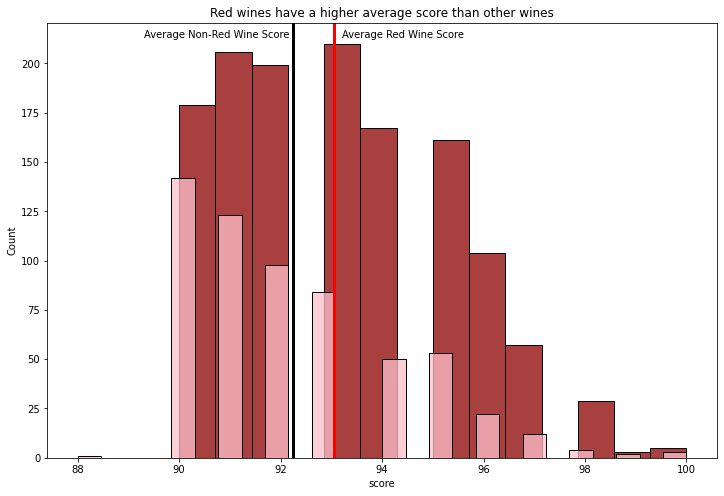

In [9]:
explore.get_q1_viz(train)

In the above visuzalization, there is a clear difference in red wines average score and other wines average score. This suggests wines designated as red will score higher.

#### Hypothesis 1 - Red Wine Score
- Ho -> The mean score of red wine is equal to or less than all other wines mean score
- Ha -> The mean score of red wine is greater than all other wines mean score
- T-Test: Two-Sample, One-Tail

In [10]:
explore.get_q1_stats(train)

Reject the Null Hypothesis.
    Findings suggest the mean score of red wine is greater than the mean score of all other wines. 



#### Question 1 Takeaways:
- Red wines score higher than other wines on average
- Most wines score between 90 and 95 points
----

### Question 2: Is there a linear relationship between a wine's price and its score?

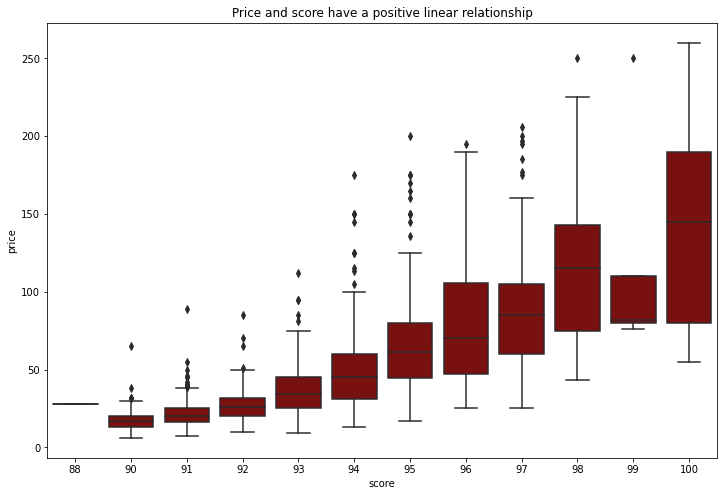

In [11]:
explore.get_q2_viz(train)

The above visuzalization depicts the increasing price as score also increases. This remains consistent with a score of 99 points being the exception. 

#### Hypothesis 2 - Wine score and price
- Ho -> There is no linear relationship between a wine's score and its price
- Ha -> There is a linear relationship between a wine's score and its price
- Spearman's Correlation due to price not being normally distributed

In [12]:
explore.get_q2_stats(train)

Reject the Null Hypothesis.
    Findings suggest there is a linear relationship between a wine's score and its price.
    Spearman's Correlation was: 0.795



#### Question 2 Takeaways:
- There is a strong positive linear relationship between a wine's score and its price
----

### Question 3: Do highly scored wines rank higher?

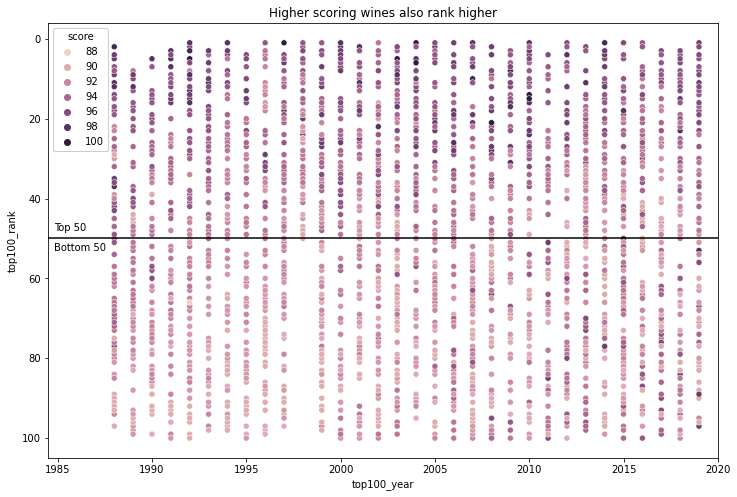

In [13]:
explore.get_q3_viz(train)

In the visualization above, you can see the higher scoring wines (darker dots), tend to rank better (closer to #1 spot) year to year

#### Hypothesis 3: Rank and Score
- Ho -> The average score of wines ranking in the top 50 is less than or equal to the average score of wines ranking in the bottom 50
- Ha -> The average score of wines ranking in the top 50 is greater than the average score of wines ranking in the bottom 50
- T-Test: Two-Sample, One-Tail

In [14]:
explore.get_q3_stats(train)

Reject the Null Hypothesis.
    Findings suggest the mean score of wines ranking in the top 50 is higher.



#### Question 3 Takeaways:
- The higher ranked wines have a higher average score
----

### Question 4: Does location play a role in score?

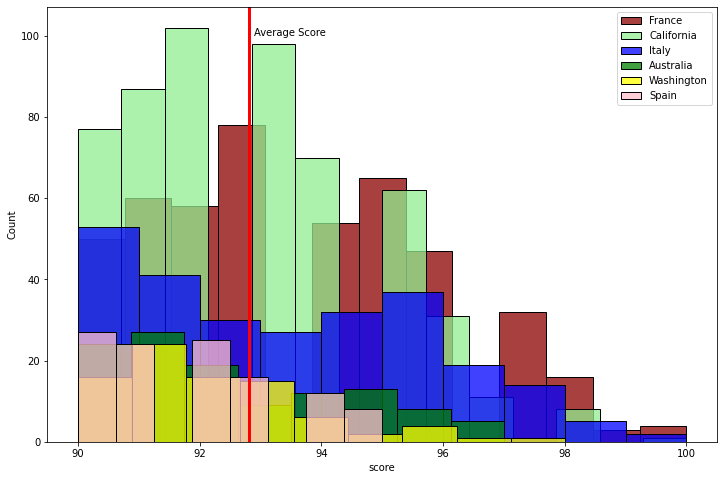

In [15]:
explore.get_q4_viz(train)

In the above visualization, most countries seem to peak around the average population score. France looks to be the exception to this. Let's test it out with a t-test below.

#### Hypothesis 4: Location and Score
- Ho -> The average score of wines from France is lower than or equal to the populations average score
- Ha -> The average score of wines from France is greater than the populations average score
- T-Test: One-Sample, One-Tail

In [16]:
explore.get_q4_stats(train)

Reject the Null Hypothesis.
    Findings suggest the mean score of wines from France is higher than the population average.



#### Question 4 Findings:
- Wine from France tends to have a higher score than the average population score
----

### Question 5: How do words in the tasters' notes change for wines above and below the average score?

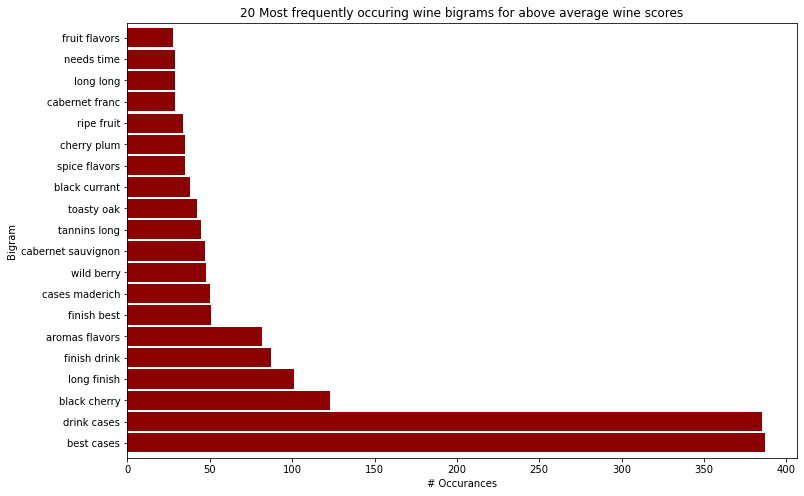

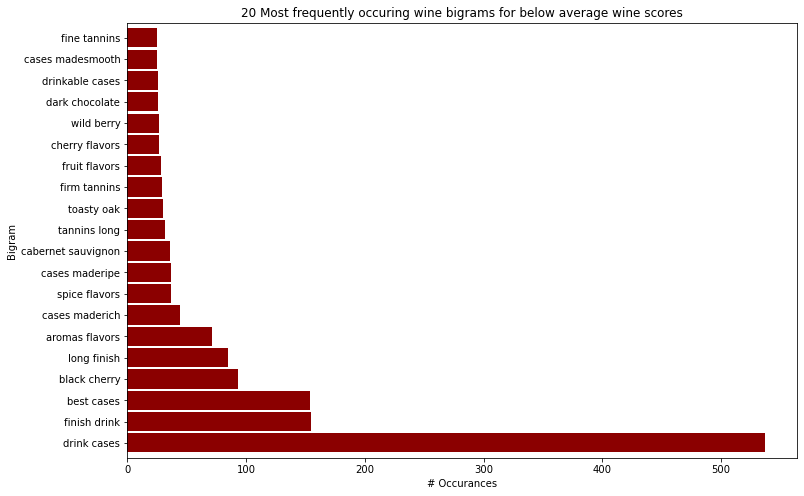

In [17]:
explore.get_q5_viz(train)

#### Question 5 Takeaways:
- Bigrams like 'drink cases' or 'cabernet sauvignon' appear in both
- Bigrams referencing tannins seem to depict above average score wines
- Bigrams referencing 'wild berry' or 'finish best' seem to depict below acerage score wines
----

### Data Exploration Takeaways

- Red wines score higher than other wines on average
- There is a linear relationship between price and score
- Higher ranked wines have a higher average score
- French wines tend to score higher than the population average
- There are some words that show up more often in above average scoring wines than below. However, these lines are blurry.
----

## 5. Modeling
#### My goal is to maximize accuracy and correct predicitons of score.

Most features were kept in the modeling phase. Those dropped were captured in feature engineering or were not found relevant in scoring a bottle.

| Features Dropped | Features Kept |
| ---- | ---- |
| winery | vintage |
| wine | price | aged |
| issue_year | top100_rank |
| top100_year | red |
| note | white |
|  | location dummies |
|  | note dummies |

In [18]:
models, final = model.run_models(train, val, test)

In [19]:
models

,train_accuracy,train_rmse,validate_accuracy,validate_rmse
baseline,0.153605,4.824974,NaN,NaN
logit,0.415361,1.331830,0.339593,1.404219
tree,0.443574,1.128615,0.436620,1.130042
forest,0.718913,0.999739,0.446009,1.190074


In [20]:
final.T

,accuracy,rmse
train,0.443574,1.128615
validate,0.436620,1.130042
test,0.383412,1.232070


#### Modeling Takeaways
- The Decision Tree model performed the best at 44% accuracy; almost 30% higher than baseline
- All of the models outperfromed baseline, but both the Logistic Regression and Random Forest models show signs of overfitting
- None of these models perform extrodinarily well in predicting a bottle's score
----

## CONCLUSION
Wine scoring is a point of pride for wineries everywhere. My best model was able to predict this scoring with 44% accuracy, but requires more data to hone in on what makes a wine truly great. 

#### Recommendations
- Add taster evaluation data on the profile (dry, sweet, full-bodied, etc.) for a professional assessment and metric to compare the wines
- Build out metrics that numerically evaluate what the criteria are for scoring

#### Next Steps
- Look into websites such as vivino.com to gather customer taste profile data
- Configure the location and winery data into a numerical form and see how that effects the model

----